## Introduction

By integrating multiple data sources from the **Sentinel** missions, we can create a powerful, multi-layered views of our Earth.<br>

**Sentinel-2** mission gives us a detailed visual of the surface through its high-resolution imagery, including True Colour Images (TCI). Meanwhile, **Sentinel-3 SLSTR** provides critical land surface temperature data.

Such integration allows us to create a dynamic visualisation. It is possible to overlay the **Sentinel-3** **Land Surface Temperature** (LST) data on top of the detailed Sentinel-2 imagery. This creates a compelling picture of an **active fire**, showing not only the location visually but also the intense heat radiating from it.<br>

This process transforms a simple image into a powerful analytical tool, allowing for the precise identification of hot spots and potential active fires.<br>

**include a sentence about the second part of the workflow** 


### By the end of this tutorial, we will be able to...



- ✂️ Extract and clip data from Sentinel-3 SLSTR L2 
- 🛰️ Visualise potential fires based on the relationship between Sentinel-2 and Sentinel-3 available items through the [EOPF STAC Catalog]()
- 🔭 Demostrate the smooth multi-mission integration capabilities `.zarr` format offers to the community

<hr>

#### Import libraries

In [1]:
from distributed import LocalCluster
from pystac_client import Client
import numpy as np
import xarray as xr
import time
import matplotlib.pyplot as plt
from pyproj import Transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from skimage import exposure
from matplotlib.colors import BoundaryNorm, ListedColormap
from shapely.geometry import box 

#### Helper functions

##### `validate_scl()`

Creates a boolean mask to identify valid pixels in a Sentinel-2 Scene Classification (SCL) dataset by excluding invalid land cover types.

Recieves:

- `scl` : An xarray.DataArray representing the Scene Classification (SCL) band from a Sentinel-2 image.

In [2]:
def validate_scl(scl):
# A list of SCL values to be considered invalid (e.g., NO_DATA, SATURATED, CLOUD)
    invalid = [0, 1, 3, 7, 8, 9]
# Return a boolean mask where True indicates a valid pixel (i.e., not in the invalid list)
    return ~scl.isin(invalid)

##### `mask_sub_utm()`
Performs the masking over a `.zarr` asset by subsetting it to a specified rectangular area defined by row and column indices.

Recieves:

- `zarr_asset` : The input Zarr array asset.
- `rows` : A list or array of row indices defining the vertical extent.
- `cols` : A list or array of column indices defining the horizontal extent.

In [3]:
def mask_sub_utm(zarr_asset, rows, cols):
# Calculates the minimum and maximum row and column indices
    row_min, row_max = rows.min(), rows.max()
    col_min, col_max = cols.min(), cols.max()
# It then subsets the zarr_asset using these indices
    masked_asset = zarr_asset.isel(
    y=slice(row_min, row_max + 1), x=slice(col_min, col_max + 1)
)
    return masked_asset

##### `normalisation_str_gm()`

Applies percentile-based contrast stretching and gamma correction to a band.

Recieves:

- `band_array` : the extracted `xarray` for the selected band
- `p_min` : percentile min value
- `p_max`: percentile max value
- `gamma_val`: gamma correction

In [4]:
def normalisation_str_gm(band_array, p_min, p_max, gamma_val):

    # Calculate min and max values based on percentiles for stretching
    min_val = np.percentile(band_array[band_array > 0], p_min) if np.any(band_array > 0) else 0
    max_val = np.percentile(band_array[band_array > 0], p_max) if np.any(band_array > 0) else 1

    # Avoid division by zero if min_val equals max_val
    if max_val == min_val:
        stretched_band = np.zeros_like(band_array, dtype=np.float32)
    else:
        # Linear stretch to 0-1 range
        stretched_band = (band_array - min_val) / (max_val - min_val)

    # Clip values to ensure they are within [0, 1] after stretching
    stretched_band[stretched_band < 0] = 0
    stretched_band[stretched_band > 1] = 1

    # Apply gamma correction
    gamma_corrected_band = np.power(stretched_band, 1.0 / gamma_val)

    # Returns the corrected array:
    return gamma_corrected_band


##### `mask_sub_latlon()`

Masks a `.zarr` asset by subsetting it to a specified rectangular area defined by row and column indices. It is intended for datasets where the dimensions are labelled as 'rows' and 'columns'.

Recieves:

- `zarr_asset` : The input `.zarr` array asset.
- `rows` : A list or array of row indices defining the vertical extent.
- `cols` : A list or array of column indices defining the horizontal extent.

In [5]:
def mask_sub_latlon(zarr_asset, rows, cols):
# Calculates the minimum and maximum row and column indices
    row_min, row_max = rows.min(), rows.max()
    col_min, col_max = cols.min(), cols.max()
# It then subsets the zarr_asset using these indices
    masked_asset = zarr_asset.isel(
    rows=slice(row_min, row_max + 1), columns=slice(col_min, col_max + 1)
)
    return masked_asset

##### `zarr_mask_latlon()`
Allows the creation of a boolean mask to identify the rows and columns within a Zarr dataset that fall within a specified bounding box, assuming latitude and longitude dimensions.

Recieves:

- `bounding_box` : A tuple or list containing (min_longitude, min_latitude, max_longitude, max_latitude).
- `zarr` : The input Zarr dataset, expected to have 'longitude' and 'latitude' dimensions.

In [6]:
def zarr_mask_latlon ( bounding_box, zarr):
# Unpack the bounding box coordinates for clarity
    min_lon, min_lat, max_lon, max_lat = bounding_box
# Create boolean masks for longitude and latitude dimensions based on the bounding box
    lon_mask = (zarr['longitude'] >= min_lon) & (zarr['longitude'] <= max_lon)
    lat_mask = (zarr['latitude'] >= min_lat) & (zarr['latitude'] <= max_lat)
# Combine the individual masks to create a single bounding box mask
    bbox_mask = lon_mask & lat_mask
# Find the row and column indices where the combined mask is True
    cols, rows  = np.where(bbox_mask)

    return rows, cols

##### `lat_lon_to_utm_box()`

Converts the latitude and longitude coordinates of a bounding box from a geographic system to the UTM (Universal Transverse Mercator) coordinate system.

Recieves:

- `bot_left` : A tuple or list containing the longitude and latitude of the bottom-left corner.
- `top_right` : A tuple or list containing the longitude and latitude of the top-right corner.

In [7]:
def lat_lon_to_utm_box(bot_left,top_right):
    # Longitude and latitude of the bottom-left corner
    west_utm, south_utm = transformer.transform(bot_left[0],bot_left[1])
    # Longitude and latitude of the top-right corner
    east_utm, north_utm = transformer.transform(top_right[0],top_right[1])

    # A new list with the converted UTM coordinates
    return [ west_utm, south_utm , east_utm , north_utm ]

<hr>

## Setting up parallel computing

Our process begins by setting up a parallel computing environment.<br>

This allows us to handle large datasets efficiently by creating a **virtual cluster** right on our local machine.<br>
Think of this cluster as a team: it has a scheduler (the "brain") that organises tasks and several workers (the "hands") that do the heavy lifting. By distributing the workload, this virtual team processes data much faster than a single core could.<br>
We will then create a client to act as the communication hub, managing the flow of instructions between our code and the cluster. 

This powerful setup ensures a smooth and efficient workflow for handling our large satellite datasets.

For more information, feel free to visit the **dask** [documentation](https://docs.dask.org/en/stable/) and the tutorial [How to use dask](http://docs.dask.org/en/stable/#how-to-use-dask).

In [8]:
# we are interested in the performance the code will have
st = time.time()


cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52268,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:52284,Total threads: 2
Dashboard: http://127.0.0.1:52285/status,Memory: 4.80 GiB
Nanny: tcp://127.0.0.1:52271,


### STAC Connection
Data is retrieved from the [EOPF STAC Catalogue]() endpoint. Once connected, a bounding box and a date range need to be defined to specify the area and time of interest. For the first part of our workflow, we will focus on the Sentinel-3 SLSTR collection.

In [9]:
eopf_stac_api_root_endpoint = "https://stac.core.eopf.eodc.eu/" #root starting point
eopf_catalog = Client.open(url=eopf_stac_api_root_endpoint) # calls the selected url
eopf_catalog

<Client id=eopf-sample-service-stac-api>

## The Event

On **June 10th, 2025**, a significant wildfire in Italy's Nuoro Province in Sardinia burned approximately 1000 hectares, a scale that is clearly visible in satellite imagery with a 20-meter resolution. [The European Forest Fire Information System (EFFIS)](https://forest-fire.emergency.copernicus.eu/apps/effis_current_situation/) keeps record of this events.


To pinpoint this specific event, we will need to query the [EOPF Sentinel STAC Catalog](https://stac.browser.user.eopf.eodc.eu/?.language=en), filtering and processing for items that match the following criteria and workflow:

- **Defining the area of interest (AOI)**: We define the bounding box that encapsulates the burnt area.
- **Coordinate Reprojection**: The initial AOI will be in WGS84 coordinates. For a matching overlay, we will need to reproject this to a different coordinate reference system (CRS) that is better suited for spatial analysis and aligns with our satellite data.
- **Masking and Validation**: We will then use the reprojected bounding box to precisely mask the retrieved items, isolating only the area of interest
- **Final Masking**: Finally, we will create a precise Boolean mask based on the latitude and longitude coordinates, allowing us to focus our analysis exclusively on the burnt area.

As **Sentinel-2** has a **revisit** time of **5 days**, the closest available image to this day, corresponds to the 11th of June 2025.

In [10]:
# The timeframe and area of interest for our filtering
fire_d = '2025-06-11'
fire_d_s3 = '2025-06-10'
def_collection = ''

search_bbox = (8.847198,40.193395,8.938865,40.241895)

# Definition of the transformer parameters for reprojection and correct overlay of layers
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32632", always_xy=True)
t_utm_to_deg = Transformer.from_crs("EPSG:32632","EPSG:4326", always_xy=True)

# Defining a larger bounding box for better visualisation:
bbox_vis = (8.649555,40.073583,9.127893,40.343840)

# A fixed geographic bounding box to highlight the AOI in the map format
map_box = search_bbox

# A new list with the converted UTM coordinates
bbox_utm = lat_lon_to_utm_box((bbox_vis[0], bbox_vis[1]),(bbox_vis[2], bbox_vis[3]))

# # Convert the coordinates of the map_box
# map_box = lat_lon_to_utm_box((map_box[0], map_box[1]),(map_box[2], map_box[3]))

## Land Surface Temperature (LST) Sentinel-3 SLSTR L2

Complementary information to Earths surface visualisation, like Land Surface Temperature (LST) data, can be retrieved from the Sentinel-3 SLSTR L2 collection.<br>
This data helps identify temperature anomalies over the Earth's Surface, which can be strong indicators of an active fire front.

Following the principle presented along [EOPF 101](https://eopf-toolkit.github.io/eopf-101/33_eopf_stac_connection.html) **Access the EOPF Zarr STAC API with Python** tutorial, the collection of interest is defined.

This search introduces a new argument to the search: `query`. This argument allows us to go into the `.zarr` attributes metadata and filter based on specific parameters, the items we are interested in. We will filter for "**Non-Time Critical**" items for a first view.


In [11]:
# Specifying the Sentinel-3 SLSTR L2 LST collection name
def_collection = 'sentinel-3-slstr-l2-lst'

# Search the catalog for items matching the criteria:
s3_l2 = list(eopf_catalog.search(
                bbox= search_bbox,  # A bounding box input to define the area of interest
                datetime= fire_d_s3, # A datetime string input to specify the time range
                collections=def_collection, # The collection name to search within
                query = {"product:timeliness_category": {'eq':'NT'}} # A query to filter by timeliness category
                                                                     # in the Catalog
                ).item_collection())

# Extract the URLs for the product assets from the search results
av_urls = [item.assets["product"].href for item in s3_l2]

print("Search Results:")
print('Total Items Found for Sentinel-3 SLSRT over Sardinia:  ',len(av_urls))

Search Results:
Total Items Found for Sentinel-3 SLSRT over Sardinia:   5


In [12]:
av_urls

['https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202506-s03slslst/10/products/cpm_v256/S3A_SL_2_LST____20250610T211428_20250610T211728_20250612T084018_0179_127_029_0540_PS1_O_NT_004.zarr',
 'https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202506-s03slslst/10/products/cpm_v256/S3B_SL_2_LST____20250610T203544_20250610T203844_20250612T050909_0179_107_271_0540_ESA_O_NT_004.zarr',
 'https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202506-s03slslst/10/products/cpm_v256/S3A_SL_2_LST____20250610T095734_20250610T100034_20250611T211817_0180_127_022_2340_PS1_O_NT_004.zarr',
 'https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202506-s03slslst/10/products/cpm_v256/S3A_SL_2_LST____20250610T095434_20250610T095734_20250611T211757_0179_127_022_2160_PS1_O_NT_004.zarr',
 'https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202506-s03slslst/10/products/cpm_v256/S3B_SL_2_LST____20250610T091849_20250610T092149_20250611T160034_0179_107_264_2340_ESA_O

After filtering the catalog, we open the **first** available Sentinel-3 SLSTR item, which corresponds to our specific timeframe in the selected day(the earliest generated one). 

For optimising the subsequent plotting, we can extract key information from this data item, such as the date and the specific item time. Afterwards, we access the **Land Surface Temperature** (LST) asset. The LST data, organised within a measurement group, is stored for processing and visualisation, as it is our interest variable.


In [13]:
# Open the last item from the list of URLs as a Zarr data tree
lst_zarr = xr.open_datatree(
    av_urls[-1], # Input: URL of the last Zarr item in the av_urls list
    engine="zarr" # Specify the Zarr engine for opening the file
    )

# Extract the start date and time from the data tree's metadata
date_zarr_lst = lst_zarr.attrs['stac_discovery']['properties']['start_datetime'][:10]
time_zarr_lst = lst_zarr.attrs['stac_discovery']['properties']['start_datetime'][11:19]

# Access the 'measurements' group within the data tree
meas_lst = lst_zarr.measurements
# The output is the measurements data group
meas_lst

ClientConnectorCertificateError: Cannot connect to host objects.eodc.eu:443 ssl:True [SSLCertVerificationError: (1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1016)')]

To effectively overlay the data, we first need to process the Land Surface Temperature (LST) asset to cover the same area of interest.
We can accomplish this by applying our pre-defined masking functions. Since the LST data is presented in **EPSG:4326**, we will use the `zarr_mask_latlon()` function to generate the boolean mask of interest over the data, followed by the `mask_sub_latlon()` function, which clips it to our specific area.<br>

After defining our interest layer, we apply the **temperature threshold** to the data, filtering for only those pixels with **temperatures above 313 Kelvin**.<br>
This temperature range is a strong indicator of heat anomalies, which are often associated with active or developing fires.

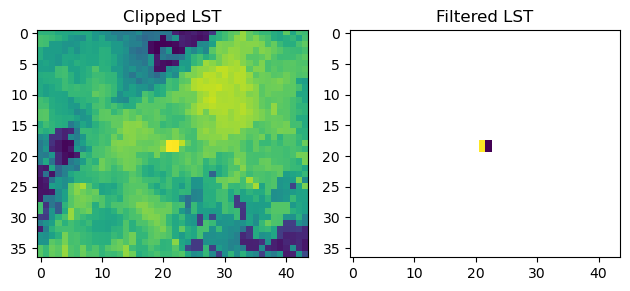

In [ ]:
# The zarr_mask_latlon function is used to create a mask based on a bounding box and the measurements data
cols_lst , rows_lst = zarr_mask_latlon(
    bbox_vis, # The input bounding box
    meas_lst # The measurements group from the zarr data tree
    )
# The mask_sub_latlon function then clips the land surface temperature data
lst_clip = mask_sub_latlon(
    meas_lst.lst, # The land surface temperature band from the measurements group
    rows_lst, # The row indices for the mask
    cols_lst # The column indices for the mask
    ).values

# The latitude data is clipped using the same mask indices
lat_lst = mask_sub_latlon(meas_lst['latitude'],rows_lst, cols_lst).values
# The longitude data is clipped using the same mask indices
lon_lst = mask_sub_latlon(meas_lst['longitude'],rows_lst, cols_lst).values

# To clip the data and prepare the array for an overlay with the TCI:
lstf_clip = np.where(
    lst_clip <= 310, # values less than or equal to 310 K
    np.nan, # The value to assign if the condition is true
    lst_clip # The value to assign if the condition is false
    )


# Create a figure to plot
fig, axs = plt.subplots(1, 2)
axs[0].imshow(lst_clip)
axs[0].set_title('Clipped LST')
# Plot the filtered land surface temperature data on the second subplot
axs[1].imshow(lstf_clip)
axs[1].set_title('Filtered LST') # Add a title for clarity
# Adjust the layout
fig.tight_layout()
# Display the plot
plt.show()

The final step of the Sentinel-3 SLSTR data process is to **visualise** the temperature anomalies.<br>

We will prepare the filtered LST data for overlay over the TCI image.<br>
Creating a custom colour map that uses shades of red, with the most **vibrant red** indicating the **hottest** areas will enhance our visualisation. This colour map is applied to the LST data, allowing us to clearly and intuitively see the heat signatures that correspond with potential fire activity when the two layers are overlayed.


In [ ]:
# For colour ramp:
col_map = ListedColormap([[1., 140./255., 0],[178./255., 34./255., 34./255.],[1, 0, 0]]) # red composite shades
# Define the boundaries for each colour in the ramp
bounds = [300, 305, 310, 315]
# Calculate the number of colours, which is one less than the number of bounds
ncolors = len(bounds) - 1
# Create a normalisation object to map data values to colours based on the defined bounds
norm = BoundaryNorm(bounds, col_map.N)

# Use the box() function to create a polygon from the coordinates
map_box = box(map_box[0],map_box[1],map_box[2],map_box[3])

## Optical Visualisation Sentinel-2 L2A

To visualise our area of interest, we will create imagery from **Sentinel-2 L2A**. This process involves creating a TCI view by combining various spectral bands. These bands capture light at different wavelengths, each providing unique and valuable information about the Earth's surface. <br>

Following the parameters we defined earlier and the workflow described in the [first notebook](), we will filter the **Sentinel-2 L2A** data collection to match our event and AOI. This ensures that the visualisations we create are directly relevant to the fire event and set the stage for overlaying our temperature data.


In [ ]:
# Interest timeframe parameters for the filtering
date_p = fire_d + 'T00:00:00Z/' + fire_d + 'T23:59:59.999999Z' # interest period
def_collection = 'sentinel-2-l2a' # collection
s2_col = list(eopf_catalog.search(
                bbox= search_bbox, # area
                datetime= date_p, #time frame
                collections=def_collection # collection
                ).item_collection())

av_urls = [item.assets["product"].href for item in s2_col] 

Once we have obtained the available and interest items from the **Sentinel-2 L2A** collection, we select the **earliest** available item to ensure we retrieve (also corresponding to the first image captured during the fire day). <br>
To prepare the data for the analysis, we will extract key metadata like the collection, date, time, and the spectral bands needed for the visualisations (which are conveniently grouped under `r20m` group). <br>

These steps include:
- Data quality filtering
- Masking
- Band selection
- Normalisation
- Stacking
- Equalisation


In [ ]:
# We are interested in the datasets contained in the measurements bands for True Colour and False Colour Composites.
s2_zarr = xr.open_datatree(
    av_urls[-1], engine="zarr", #we always get the earliest one (the first available item goes last)
    chunks={},
    )

# Store interest parameters for further plotting:
date = s2_zarr.attrs['stac_discovery']['properties']['start_datetime'][:10]
time_zarr = s2_zarr.attrs['stac_discovery']['properties']['start_datetime'][11:19]
target_crs = s2_zarr.attrs["stac_discovery"]["properties"]["proj:epsg"]
# Extract the resolution group we are interested to analyse over:
zarr_meas = s2_zarr.measurements.reflectance.r20m

# Extractthe cloud free mask at 20m resolution:
l2a_class_20m = s2_zarr.conditions.mask.l2a_classification.r20m.scl
valid_mask = validate_scl(l2a_class_20m)  # Boolean mask (10980x10980)

/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_2609/108725901.py:2: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  s2_zarr = xr.open_datatree(
/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_2609/108725901.py:2: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which 

### True Colour Image

To get a familiar view of the fire, a TCI is created.<br>
This composite uses the red (B04), green (B03), and blue (B02) bands to produce an image that looks natural to the human eye. This generation considers a larger extent than the specific fire area to better detect the event's overall spatial impact.<br>

In [ ]:
# True colour channels we are interested to retrieve coposite:
tc_red  = 'b04'
tc_green= 'b03'
tc_blue = 'b02'

# Boolean mask for the 'x' dimension (longitude/easting)
x_mask = (zarr_meas['x'] >= bbox_utm[0]) & (zarr_meas['x'] <= bbox_utm[2])
# Boolean mask for the 'y' dimension (latitude/northing)
y_mask = (zarr_meas['y'] >= bbox_utm[1]) & (zarr_meas['y'] <= bbox_utm[3])

# Combined mask for the bounding box
bbox_mask = x_mask & y_mask

# Extract row and column indices where the mask is True
cols, rows = np.where(bbox_mask)

As the information is extracted and the masks are generated, we proceed to apply the workflow described in section [thse]() of the [tutorial]().<br>

Text(0.5, 1.0, 'Equalised Composite')

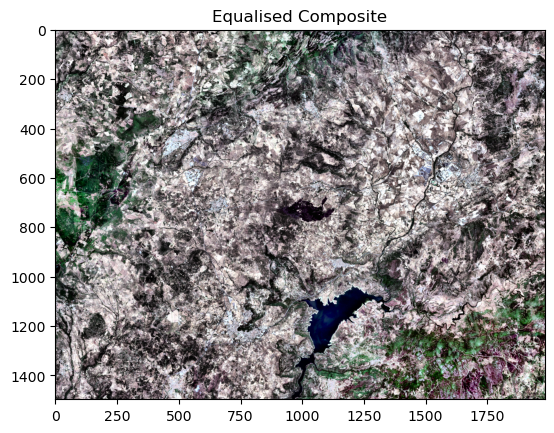

In [ ]:
# The tc_red, tc_green, and tc_blue variables are inputs specifying the band names
red = zarr_meas[tc_red].where(valid_mask)
gre =  zarr_meas[tc_green].where(valid_mask)
blu =  zarr_meas[tc_blue].where(valid_mask)

# The mask_sub_utm() function takes the bands and masks them to the valid rows and columns
red = mask_sub_utm(red,rows, cols).values
gre = mask_sub_utm(gre,rows, cols).values
blu = mask_sub_utm(blu,rows, cols).values

# The zarr_meas group is the input dataset containing the dimensions
# by slicing the 'y' dimension array based on the minimum and maximum row indices
y_zarr = zarr_meas['y'].isel(y=slice(rows.min(), rows.max() + 1)).values
# also, the same for the 'x' dimension array based on the minimum and maximum column indices
x_zarr = zarr_meas['x'].isel(x=slice(cols.min(), cols.max() + 1)).values

map_ext_deg = list(t_utm_to_deg.transform(np.nanmin(x_zarr),np.nanmin(y_zarr)) + 
                   t_utm_to_deg.transform(np.nanmax(x_zarr),np.nanmax(y_zarr)))

# Input: percentile range for contrast stretching
contrast_stretch_percentile=(2, 98)
# Input: gamma correction value
gamma=1.8

# Apply normalisation to the red, green and blue bands using the specified percentile and gamma values
red_processed = normalisation_str_gm(red, *contrast_stretch_percentile, gamma)
green_processed = normalisation_str_gm(gre, *contrast_stretch_percentile, gamma)
blue_processed = normalisation_str_gm(blu, *contrast_stretch_percentile, gamma)

# We stack the processed red, green, and blue arrays
rgb_composite_sm = np.dstack((red_processed, green_processed, blue_processed)).astype(np.float32)

#Adding equalisation from skimage:
fire_tc = exposure.equalize_adapthist(rgb_composite_sm)


plt.imshow(fire_tc)
plt.title('Equalised Composite') # Add a title for clarity

And finally, we can **georeference** and overlay in a much more appealing way through the `cartopy` library, both our TCI and the LST filtered layer.


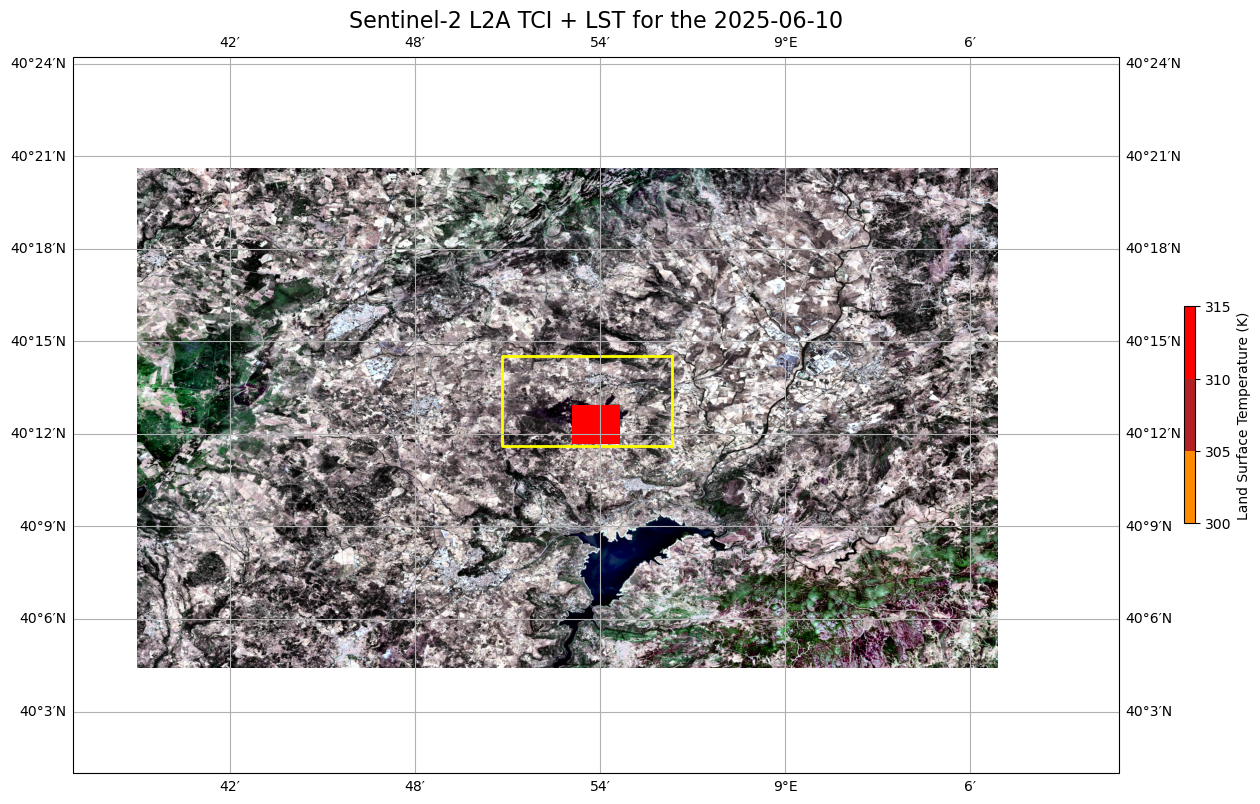

In [ ]:
#Overlay
plt.figure(figsize=(14, 8))
# Define the coordinate reference system (CRS) for latitude/longitude
data_ll = ccrs.PlateCarree()

ax = plt.axes(projection=data_ll)
# Display the Sentinel-2 true-colour composite (TCI) image
img = ax.imshow(fire_tc, origin='upper',
                extent=[map_ext_deg[0],map_ext_deg[2],map_ext_deg[1],map_ext_deg[3]],  # item
                transform=data_ll)
# Display the land surface temperature (LST) data as an overlay
im2 = ax.imshow(lstf_clip, origin='upper',
                extent=[np.nanmin(lon_lst), np.nanmax(lon_lst),
                        np.nanmin(lat_lst), np.nanmax(lat_lst)],
                transform=data_ll, # coordinates
                cmap=col_map,  norm=norm) # The custom colour map for LST
cbar = plt.colorbar(im2,ticks=bounds, shrink=0.3)
cbar.set_label("Land Surface Temperature (K)")


# features
ax.add_geometries(map_box, crs=data_ll, facecolor='none', edgecolor='yellow', linewidth=2, linestyle='-')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False) # Add gridlines and labels

# Adjust title and plot parameters for a tight layout
plt.title(f'Sentinel-2 L2A TCI + LST for the {fire_d_s3}', fontsize=16)
plt.tight_layout()
plt.show()

This combined visualisation is powerful as it allows us to connect the TCI (what we can see) with the crucial thermal evidence (through LST).<br>

The **Sentinel-2 L2A** provides the geographical context of the landscape, while the **Sentinel-3 SLSTR** pinpoints the hottest areas. This allows for a more accurate and immediate understanding of a fire's behaviour during the event. We can see that the hottest detected spot over the area of interest is indeed aligned with the fire event location.<br>

The overlay provides additional information, especially in conditions where optical views are limited. For example, during less light hours or through heavy smoke, the thermal data can still reveal the fire's true footprint. This **multi-layered** approach ensures continuous monitoring for fire management teams' response.

In [ ]:
et = time.time()

total_t = et - st

print('Total Running Time: ', total_t,' seconds')

Total Running Time:  23.67595386505127  seconds


A significant takeaway from this process is its remarkable speed. The entire workflow, from data access to visualisation, is completed in under a minute. Here is the key evident advantage of using `.zarr` encoding for wildfire detection. <br>
The format’s **smoothness for data retrieval and integration** enables us to quickly access and combine large datasets directly from the cloud without the need for lengthy downloads, making it an ideal solution for time-sensitive applications.

<hr>

## Conclusion

By integrating items from **Sentinel-2** with critical thermal data from **Sentinel-3** through the [EOPF STAC Catalog]() Collections, this notebook has demonstrated a complete and efficient workflow for analysing a real-world wildfire event. <br>

We were able to create **a powerful overlay** that not only shows the **geographical context** of the **burnt area** but also precisely **identifies** the active **heat signatures** associated with the fire. This approach proves that combining different types of satellite data is essential for gaining a complete understanding of complex environmental events.<br>

Ultimately, this workflow highlights the transformative power of modern, cloud-native data formats.<br>
Using `.zarr` encoding, we were able to process and integrate massive datasets in under a minute. This speed and efficiency, driven by parallel computing, make it possible for anyone to perform complex geospatial analysis directly from the cloud without needing to download multiple heavy files. 

<hr>

## What’s next?

Building on our visual analysis, the next tutorial will introduce a quantitative method to assess fire severity.<br>
We will calculate the **Normalised Burn Ratio** (NBR) using data from **Sentinel-2** satellite imagery.